In [44]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1 for disable CUDA


import numpy as np
import tensorflow as tf
import csv
CSV_DATA = "daily-min-temp.csv"

In [45]:
time_step = []
temps = []

with open(CSV_DATA) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step=step + 1

series = np.array(temps)
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [46]:
series2_norm = np.random.rand(len(series))

In [55]:
# Normalizing series (it's min-max scaling right?) Yep...
min=np.min(series)
max=np.max(series)
series_norm = (series - min) / (max - min)
series_norm

array([0.78707224, 0.68060837, 0.7148289 , ..., 0.51330798, 0.59695817,
       0.49429658])

In [154]:
# DO NOT CHANGE THIS CODE
split_time=2500

# Training Data
series1_train = series_norm[:split_time]
series2_train = series2_norm[:split_time]

# Testing
series1_test = series_norm[split_time:]
series2_test = series2_norm[split_time:]

In [155]:
# DO NOT CHANGE THIS CODE
window_size=64
batch_size=256
shuffle_buffer_size=1000

# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#     series = tf.expand_dims(series, axis=-1)
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     ds = ds.shuffle(shuffle_buffer)
#     ds = ds.map(lambda w: (w[:-1], w[1:]))
#     return ds.batch(batch_size).prefetch(1)

# train_set=windowed_dataset(
#         x_train, window_size, batch_size, shuffle_buffer_size)
# test_set=windowed_dataset(
#         x_valid, window_size, batch_size, shuffle_buffer_size)

In [158]:
# Target shape size (batch_size, timesteps, num_features)
def multivariate_window(timesteps, target_series, *series):
    reshaped_series = []
    max_datasets = len(series[0][0]) - timesteps
    for i in range(len(series[0])):
        reshaped_series.append(series[0][i].reshape((-1,1)))
    reshaped_series = np.asarray(reshaped_series)
    reshaped_series = reshaped_series.reshape((len(series[0][0]), len(series[0])))
    x = np.asarray([reshaped_series[i:timesteps+i] for i in range(max_datasets)])
    y = np.asarray([target_series[timesteps+i] for i in range(max_datasets)]).reshape(-1)
    return x, y

x_train, y_train = multivariate_window(window_size, series1_train, [series1_train, series2_train])
x_test, y_test = multivariate_window(window_size, series1_test, [series1_test, series2_test])

In [159]:
main_model=tf.keras.models.Sequential([
            # YOUR CODE HERE.
            tf.keras.layers.Input(shape=(window_size, 2)),
            tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                                strides=1, padding="causal",
                                activation="relu"),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),
    ])

In [163]:
class TargetCallbacks(tf.keras.callbacks.Callback):
    MAX_CONSECUTIVE = 10
    consecutive_target = 0

    target = "mean_absolute_error"
    val_target ="val_mean_absolute_error"

    desired = 0.019

    def on_epoch_end(self, epoch, logs=None):
        if (logs[self.target] < self.desired) and (logs[self.val_target] < self.desired):
            self.consecutive_target += 1
            if self.consecutive_target >= 5:
                self.model.stop_training=True
        else:
            self.consecutive_target = 0

def create_model(model, weights):
    model1=tf.keras.models.clone_model(model)
    model1.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=["mean_absolute_error"])
    model1.set_weights(weights)
    
    model2=tf.keras.models.clone_model(model)
    model2.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=["mean_absolute_error"])
    model2.set_weights(weights)
    return model1, model2

In [164]:
model1, model2 = create_model(main_model, main_model.get_weights())
# Check if points to same model
print(hex(id(model1)))
print(hex(id(model2)))

0x268dd77e6a0
0x268dd233850


In [165]:
# My own preprocessing
tf.random.set_seed(2022)
model1.fit(x_train, y_train, epochs=100, shuffle=True, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[TargetCallbacks()])

Epoch 1/100
10/10 [==============================] - 8s 416ms/step - loss: 0.0385 - mean_absolute_error: 0.2275 - val_loss: 0.0136 - val_mean_absolute_error: 0.1362
Epoch 2/100
10/10 [==============================] - 3s 316ms/step - loss: 0.0128 - mean_absolute_error: 0.1288 - val_loss: 0.0129 - val_mean_absolute_error: 0.1328
Epoch 3/100
10/10 [==============================] - 3s 319ms/step - loss: 0.0121 - mean_absolute_error: 0.1265 - val_loss: 0.0145 - val_mean_absolute_error: 0.1401
Epoch 4/100
10/10 [==============================] - 3s 325ms/step - loss: 0.0119 - mean_absolute_error: 0.1240 - val_loss: 0.0124 - val_mean_absolute_error: 0.1307
Epoch 5/100
10/10 [==============================] - 3s 335ms/step - loss: 0.0116 - mean_absolute_error: 0.1224 - val_loss: 0.0125 - val_mean_absolute_error: 0.1312
Epoch 6/100
10/10 [==============================] - 3s 332ms/step - loss: 0.0117 - mean_absolute_error: 0.1230 - val_loss: 0.0131 - val_mean_absolute_error: 0.1336
Epoch 7/10

KeyboardInterrupt: 

In [166]:
a = model1.predict(x_test)

34/34 [==============================] - 2s 28ms/step


In [167]:
a_reshaped = a.reshape(-1)

In [168]:
import matplotlib.pyplot as plt

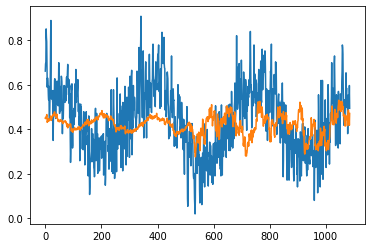

In [169]:
plt.plot(y_test)
plt.plot(a_reshaped)